<a href="https://colab.research.google.com/github/simulate111/Production-Optimization/blob/main/COLAB_PO_Assignment_1_Solution_ORDERED_FIXED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Production Optimization 2026 — Assignment 1 (2TDC)

This notebook is organized **exactly** like the assignment:
1. **Part (a):** Explicit model for items 1–3 (descending height)
2. **Part (b):** Code, solve, and present results
3. **Part (c):** Force orders 62, 78, 91 and analyze effect

*Plate dimensions:* width $W=8.0$ m, max height $H_{max}=10.0$ m.

> Upload `cutorders.xlsx` (same structure as your assignment file) to the Colab Files pane before running.


## Part (a) — Explicit model for items 1–3

In [2]:

# This cell prints the explicit numeric model using the **top 3 items** after sorting by descending height.
# It uses a triple-quoted f-string to avoid unterminated-string errors.

import pandas as pd
from IPython.display import display

W, H_max = 8.0, 10.0

df = pd.read_excel('cutorders.xlsx', engine='openpyxl')
df_sorted = df.sort_values('h', ascending=False).reset_index(drop=True)

top3 = df_sorted.iloc[:3].copy()
print('Top 3 items after sorting by height (descending):')
display(top3[['nr','order','h','w','value']])

# Extract values
h1, w1, v1, ord1, nr1 = float(top3.loc[0,'h']), float(top3.loc[0,'w']), float(top3.loc[0,'value']), int(top3.loc[0,'order']), int(top3.loc[0,'nr'])
h2, w2, v2, ord2, nr2 = float(top3.loc[1,'h']), float(top3.loc[1,'w']), float(top3.loc[1,'value']), int(top3.loc[1,'order']), int(top3.loc[1,'nr'])
h3, w3, v3, ord3, nr3 = float(top3.loc[2,'h']), float(top3.loc[2,'w']), float(top3.loc[2,'value']), int(top3.loc[2,'order']), int(top3.loc[2,'nr'])

# Build a clean multi-line text — braces are literal here, no extra escaping needed
txt = f"""
Explicit model for items 1–3 (sorted by descending height)

Items:
- j=1: nr={nr1}, order={ord1}, h1={h1}, w1={w1}, v1={v1}
- j=2: nr={nr2}, order={ord2}, h2={h2}, w2={w2}, v2={v2}
- j=3: nr={nr3}, order={ord3}, h3={h3}, w3={w3}, v3={v3}

Decision variables (binary):
  x_jk ∈ {{0,1}} for j ≥ k,  j,k ∈ {{1,2,3}}.
  x_kk = 1 opens shelf k (first item on that shelf).

Objective (maximize total area/value):
  max  {v1:.4f}·x_11 + {v2:.4f}·(x_21 + x_22) + {v3:.4f}·(x_31 + x_32 + x_33)

Constraints
1) Assignment once:
   x_11 ≤ 1
   x_21 + x_22 ≤ 1
   x_31 + x_32 + x_33 ≤ 1

2) Shelf width (active only if shelf k is opened):
   {w2:.2f}·x_21 + {w3:.2f}·x_31 ≤ (W - {w1:.2f})·x_11 = {(W - w1):.2f}·x_11
   {w3:.2f}·x_32 ≤ (W - {w2:.2f})·x_22 = {(W - w2):.2f}·x_22
   0 ≤ (W - {w3:.2f})·x_33 = {(W - w3):.2f}·x_33

3) Total stack height:
   {h1:.2f}·x_11 + {h2:.2f}·x_22 + {h3:.2f}·x_33 ≤ {H_max}
"""

print(txt)


Top 3 items after sorting by height (descending):


,nr,order,h,w,value
0,1,59,3.81,2.76,10.5156
1,2,63,3.81,1.12,4.2672
2,3,54,3.78,1.41,5.3298



Explicit model for items 1–3 (sorted by descending height)

Items:
- j=1: nr=1, order=59, h1=3.81, w1=2.76, v1=10.5156
- j=2: nr=2, order=63, h2=3.81, w2=1.12, v2=4.267200000000001
- j=3: nr=3, order=54, h3=3.78, w3=1.41, v3=5.3298

Decision variables (binary):
  x_jk ∈ {0,1} for j ≥ k,  j,k ∈ {1,2,3}.
  x_kk = 1 opens shelf k (first item on that shelf).

Objective (maximize total area/value):
  max  10.5156·x_11 + 4.2672·(x_21 + x_22) + 5.3298·(x_31 + x_32 + x_33)

Constraints
1) Assignment once:
   x_11 ≤ 1
   x_21 + x_22 ≤ 1
   x_31 + x_32 + x_33 ≤ 1

2) Shelf width (active only if shelf k is opened):
   1.12·x_21 + 1.41·x_31 ≤ (W - 2.76)·x_11 = 5.24·x_11
   1.41·x_32 ≤ (W - 1.12)·x_22 = 6.88·x_22
   0 ≤ (W - 1.41)·x_33 = 6.59·x_33

3) Total stack height:
   3.81·x_11 + 3.81·x_22 + 3.78·x_33 ≤ 10.0



## Part (b) — Code the model, solve, and present the results

> If PuLP/openpyxl are missing in Colab, run the next cell to install.

In [3]:
!pip -q install pulp openpyxl

In [4]:

# Load & prepare data
import pandas as pd, numpy as np
W, H_max = 8.0, 10.0

df = pd.read_excel('cutorders.xlsx', engine='openpyxl')
df_sorted = df.sort_values('h', ascending=False).reset_index(drop=True)
df_sorted['idx'] = np.arange(1, len(df_sorted)+1)

# Check value = h*w
df_sorted['calc_value'] = (df_sorted['h'] * df_sorted['w']).round(6)
print('Max |value - h*w| =', float((df_sorted['calc_value'] - df_sorted['value']).abs().max()))
df_sorted.head()


Max |value - h*w| = 1.7763568394002505e-15


,nr,h,w,value,order,idx,calc_value
0,1,3.81,2.76,10.5156,59,1,10.5156
1,2,3.81,1.12,4.2672,63,2,4.2672
2,3,3.78,1.41,5.3298,54,3,5.3298
3,4,3.70,2.50,9.2500,23,4,9.2500
4,5,3.65,2.55,9.3075,45,5,9.3075


In [5]:

# Build & solve (PuLP) — base scenario
import pulp

idx = df_sorted['idx'].tolist()
h = {int(r.idx): float(r.h) for r in df_sorted.itertuples()}
w = {int(r.idx): float(r.w) for r in df_sorted.itertuples()}
v = {int(r.idx): float(r.value) for r in df_sorted.itertuples()}
nr_map = {int(r.idx): int(r.nr) for r in df_sorted.itertuples()}
order_map = {int(r.idx): int(r.order) for r in df_sorted.itertuples()}

# Solver function
def solve_2tdc(df_s, must_deliver_orders=None, name='base'):
    idx = df_s['idx'].tolist()
    h = {int(r.idx): float(r.h) for r in df_s.itertuples()}
    w = {int(r.idx): float(r.w) for r in df_s.itertuples()}
    v = {int(r.idx): float(r.value) for r in df_s.itertuples()}
    nr_map = {int(r.idx): int(r.nr) for r in df_s.itertuples()}
    order_map = {int(r.idx): int(r.order) for r in df_s.itertuples()}

    prob = pulp.LpProblem(f"2TDC_{name}", pulp.LpMaximize)
    x = {(j,k): pulp.LpVariable(f"x_{j}_{k}", 0, 1, cat='Binary') for j in idx for k in idx if j>=k}

    # Objective
    prob += pulp.lpSum(v[j]*x[(j,k)] for j in idx for k in idx if j>=k)

    # Assignment once
    for j in idx:
        prob += pulp.lpSum(x[(j,k)] for k in idx if j>=k) <= 1

    # Width per shelf
    for k in idx:
        prob += pulp.lpSum(w[j]*x[(j,k)] for j in idx if j>k) <= (W - w[k]) * x[(k,k)]

    # Stack height
    prob += pulp.lpSum(h[k]*x[(k,k)] for k in idx) <= H_max

    # Must-deliver
    if must_deliver_orders:
        md = set(must_deliver_orders)
        for j in idx:
            if order_map[j] in md:
                prob += pulp.lpSum(x[(j,k)] for k in idx if j>=k) == 1

    solver = pulp.PULP_CBC_CMD(msg=False)
    prob.solve(solver)
    status = pulp.LpStatus[prob.status]
    obj = pulp.value(prob.objective)

    # Extract solution
    shelves, rows = [], []
    for k in idx:
        if pulp.value(x[(k,k)]) > 0.5:
            totw, totv, items = 0.0, 0.0, []
            items.append({'idx':k,'nr':nr_map[k],'order':order_map[k],'h':h[k],'w':w[k],'value':v[k],'first_on_shelf':True}); totw+=w[k]; totv+=v[k]
            for j in [jj for jj in idx if jj>k]:
                if pulp.value(x[(j,k)])>0.5:
                    items.append({'idx':j,'nr':nr_map[j],'order':order_map[j],'h':h[j],'w':w[j],'value':v[j],'first_on_shelf':False}); totw+=w[j]; totv+=v[j]
            shelves.append({'shelf_k':k,'cut_height':h[k],'items':items,'width_used':totw,'value_sum':totv,'width_left':8.0-totw})
            for it in items:
                rows.append({'shelf_k':k,'cut_height':h[k],**it})

    import pandas as pd
    sol_df = pd.DataFrame(rows).sort_values(['shelf_k','first_on_shelf'], ascending=[True, False])
    return status, obj, shelves, sol_df

status_base, obj_base, shelves_base, sol_base = solve_2tdc(df_sorted)
print('Base status:', status_base)
print('Base objective (total area):', obj_base)
sol_base.head()


Base status: Optimal
Base objective (total area): 76.8171


,shelf_k,cut_height,idx,nr,order,h,w,value,first_on_shelf
0,1,3.81,1,1,59,3.81,2.76,10.5156,True
1,1,3.81,2,2,63,3.81,1.12,4.2672,False
2,1,3.81,3,3,54,3.78,1.41,5.3298,False
3,1,3.81,5,5,45,3.65,2.55,9.3075,False
4,7,3.54,7,7,71,3.54,2.66,9.4164,True


--- Base plan: items per shelf ---
Shelf k=1 (h=3.81): width_used=7.84, width_left=0.16


,idx,nr,order,h,w,value,first_on_shelf
0,1,1,59,3.81,2.76,10.5156,True
1,2,2,63,3.81,1.12,4.2672,False
2,3,3,54,3.78,1.41,5.3298,False
3,5,5,45,3.65,2.55,9.3075,False


Shelf k=7 (h=3.54): width_used=8.00, width_left=0.00


,idx,nr,order,h,w,value,first_on_shelf
0,7,7,71,3.54,2.66,9.4164,True
1,8,8,98,3.53,1.62,5.7186,False
2,9,9,99,3.51,1.06,3.7206,False
3,13,13,90,3.38,2.66,8.9908,False


Shelf k=20 (h=2.65): width_used=8.00, width_left=0.00


,idx,nr,order,h,w,value,first_on_shelf
0,20,20,55,2.65,2.32,6.1480,True
1,21,21,61,2.53,2.23,5.6419,False
2,22,22,10,2.26,2.24,5.0624,False
3,23,23,19,2.23,1.21,2.6983,False


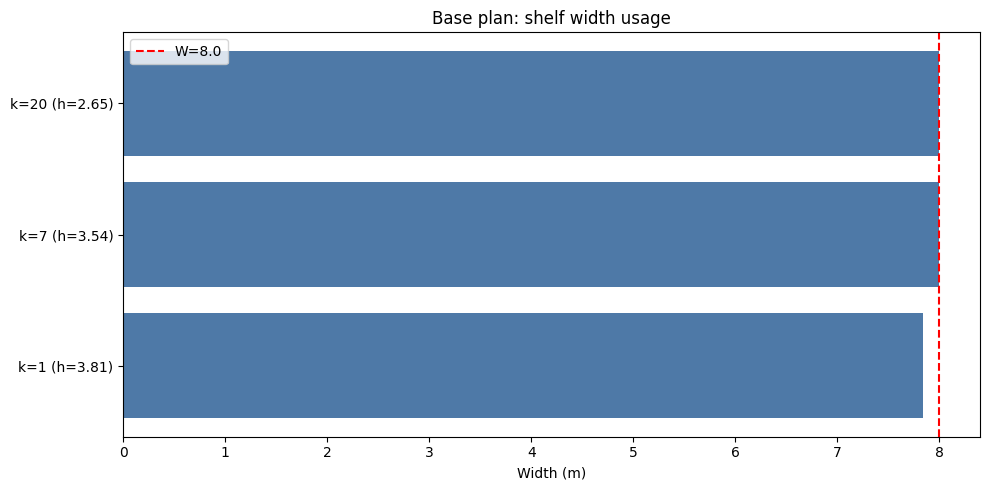

Wrote solution_base.csv


In [6]:

# Present base results + plot + CSV
import pandas as pd
from IPython.display import display
print('--- Base plan: items per shelf ---')
for s in shelves_base:
    print(f"Shelf k={s['shelf_k']} (h={s['cut_height']:.2f}): width_used={s['width_used']:.2f}, width_left={s['width_left']:.2f}")
    display(pd.DataFrame(s['items']))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
for s in shelves_base:
    plt.barh(f"k={s['shelf_k']} (h={s['cut_height']:.2f})", s['width_used'], color='#4e79a7')
plt.axvline(8.0, color='red', linestyle='--', label='W=8.0')
plt.title('Base plan: shelf width usage')
plt.xlabel('Width (m)')
plt.legend(); plt.tight_layout(); plt.show()

sol_base.to_csv('solution_base.csv', index=False)
print('Wrote solution_base.csv')


## Part (c) — Force orders 62, 78, 91 and analyze impact

Mandatory status: Optimal
Mandatory objective (total area): 75.3911
--- Mandatory plan: items per shelf ---
Shelf k=3 (h=3.78): width_used=7.98, width_left=0.02


,idx,nr,order,h,w,value,first_on_shelf
0,3,3,54,3.78,1.41,5.3298,True
1,6,6,56,3.61,1.67,6.0287,False
2,8,8,98,3.53,1.62,5.7186,False
3,10,10,52,3.50,1.18,4.1300,False
4,17,17,78,3.15,2.10,6.6150,False


Shelf k=13 (h=3.38): width_used=7.99, width_left=0.01


,idx,nr,order,h,w,value,first_on_shelf
0,13,13,90,3.38,2.66,8.9908,True
1,15,15,62,3.29,2.33,7.6657,False
2,16,16,91,3.18,3.00,9.5400,False


Shelf k=18 (h=2.83): width_used=8.00, width_left=0.00


,idx,nr,order,h,w,value,first_on_shelf
0,18,18,15,2.83,2.70,7.6410,True
1,19,19,48,2.76,1.77,4.8852,False
2,20,20,55,2.65,2.32,6.1480,False
3,23,23,19,2.23,1.21,2.6983,False


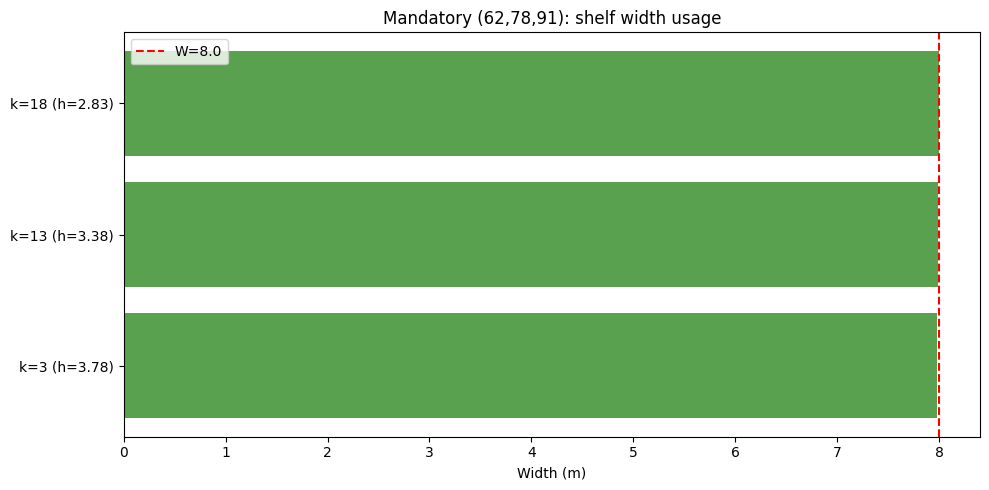

Wrote solution_mandatory.csv


In [7]:

required_orders = [62,78,91]
status_mand, obj_mand, shelves_mand, sol_mand = solve_2tdc(df_sorted, must_deliver_orders=required_orders, name='mandatory')
print('Mandatory status:', status_mand)
print('Mandatory objective (total area):', obj_mand)

import pandas as pd
from IPython.display import display
print('--- Mandatory plan: items per shelf ---')
for s in shelves_mand:
    print(f"Shelf k={s['shelf_k']} (h={s['cut_height']:.2f}): width_used={s['width_used']:.2f}, width_left={s['width_left']:.2f}")
    display(pd.DataFrame(s['items']))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
for s in shelves_mand:
    plt.barh(f"k={s['shelf_k']} (h={s['cut_height']:.2f})", s['width_used'], color='#59a14f')
plt.axvline(8.0, color='red', linestyle='--', label='W=8.0')
plt.title('Mandatory (62,78,91): shelf width usage')
plt.xlabel('Width (m)')
plt.legend(); plt.tight_layout(); plt.show()

sol_mand.to_csv('solution_mandatory.csv', index=False)
print('Wrote solution_mandatory.csv')


### Validation checks

In [8]:

import pandas as pd
sb = pd.read_csv('solution_base.csv')
sm = pd.read_csv('solution_mandatory.csv')

# Width ≤ 8
for name, s in [('base', sb), ('mandatory', sm)]:
    maxw = s.groupby('shelf_k')['w'].sum().max()
    print(name, 'max width =', maxw, '| OK' if maxw <= 8.0 + 1e-6 else '| VIOLATION')

# No duplicate items
print('duplicates in base?', sb['nr'].duplicated().any())
print('duplicates in mandatory?', sm['nr'].duplicated().any())

# Stack heights
h_base = sb[sb['first_on_shelf']].groupby('shelf_k')['h'].first().sum()
h_mand = sm[sm['first_on_shelf']].groupby('shelf_k')['h'].first().sum()
print('stack height base =', h_base)
print('stack height mandatory =', h_mand)

# Mandatory inclusion
print('mandatory present (62,78,91)?', set([62,78,91]).issubset(set(sm['order'])))


base max width = 8.0 | OK
mandatory max width = 8.0 | OK
duplicates in base? False
duplicates in mandatory? False
stack height base = 10.0
stack height mandatory = 9.99
mandatory present (62,78,91)? True



---
**Notes**
- Items are sorted by **descending height**, as required by the 2TDC model.
- Only the **first item** per shelf contributes to the total stacked height.
- Shelf width limits ensure items j>k fit next to the first item within W.
- Mandatory orders are added via equality constraints that force inclusion.
